# Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
plt.style.use('fivethirtyeight')

# Reading Data

In [2]:
df_cookie_data = pd.read_csv('attribution data.csv')
df_cookie_data.info()
display(df_cookie_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


# EDA

In [3]:
print('Total number of touch points',df_cookie_data.shape[0])
print('Number of Unique customers', len(df_cookie_data.cookie.unique()))
display('Percentage of Impressions and Conversions',df_cookie_data.interaction.value_counts())
no_of_converted_customers = df_cookie_data[df_cookie_data.conversion == 1].shape[0]
print('Percentage of converted cookies', no_of_converted_customers/len(df_cookie_data.cookie.unique()))

Total number of touch points 586737
Number of Unique customers 240108


'Percentage of Impressions and Conversions'

impression    569098
conversion     17639
Name: interaction, dtype: int64

Percentage of converted cookies 0.07346277508454528


In [4]:
df_cookie_data['time'] = pd.to_datetime(df_cookie_data.time)

df_cookie_data['visit_order'] = df_cookie_data.groupby('cookie').cumcount() + 1
df_agg_sales = df_cookie_data.groupby(by = ['cookie']).agg(net_sales = ('conversion_value','sum')).reset_index()


In [5]:
df_cookie_data[df_cookie_data.cookie.isin(['00000FkCnDfDDf0iC97iC703B','000kiDB3D0fCfDAohCDB3ohko'])]

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
123,000kiDB3D0fCfDAohCDB3ohko,2018-07-15 19:17:09+00:00,impression,0,0.0,Facebook,1
124,000kiDB3D0fCfDAohCDB3ohko,2018-07-26 16:16:21+00:00,conversion,1,7.5,Facebook,2


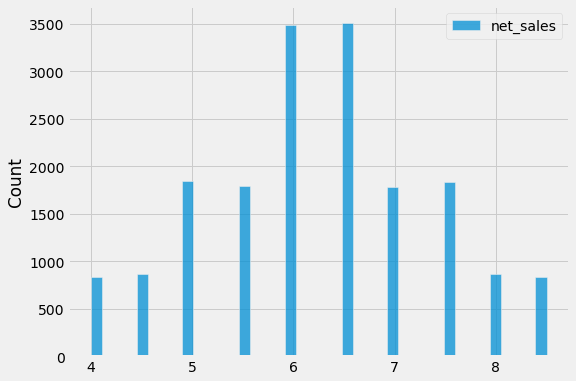

In [6]:
fig,axs = plt.subplots(1,1,figsize = (8,6))
sns.histplot(df_agg_sales[df_agg_sales.net_sales > 0],ax = axs)
plt.show()

In [7]:
converted_cookies = list(df_cookie_data[df_cookie_data.conversion == 1].cookie)
df_touch_points = df_cookie_data[df_cookie_data.cookie.isin(converted_cookies)].groupby(
    by = ['cookie']).agg(touch_points = ('conversion','count')).reset_index()


In [8]:
display(pd.DataFrame(df_touch_points.touch_points.describe()))

,touch_points
count,17639.000000
mean,3.653608
std,5.423600
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,134.000000


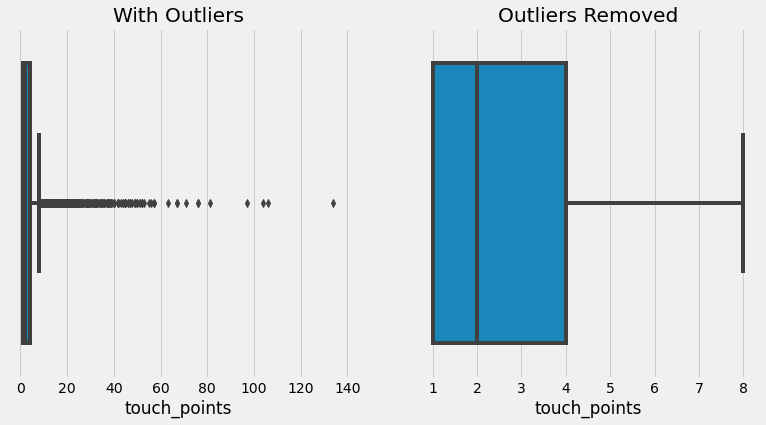

In [9]:
fig,axs = plt.subplots(1,2, figsize = (12,6))
sns.boxplot(x=df_touch_points.touch_points, ax = axs[0])
axs[0].set_title('With Outliers')
sns.boxplot(x=df_touch_points.touch_points, ax = axs[1],showfliers = False)
axs[1].set_title('Outliers Removed')
plt.show()

# DATA PREPROCESSING

In [11]:
df_paths = df_cookie_data.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
df_last_interaction = df_cookie_data.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
def path_func(row):
    if row.conversion == 0:
        return ['Start'] + row.channel + ['Null']
    else:
        return ['Start'] + row.channel + ['Conversion']
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


In [12]:
df_paths['path'] = df_paths.apply(lambda x: path_func(x),axis=1)

In [13]:
df_paths = df_paths[['cookie', 'path']]
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"


In [14]:
df_paths[df_paths.cookie.isin(['00000FkCnDfDDf0iC97iC703B','000kiDB3D0fCfDAohCDB3ohko'])]

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
44,000kiDB3D0fCfDAohCDB3ohko,"[Start, Facebook, Conversion]"


In [15]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

In [16]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [17]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

<AxesSubplot:>

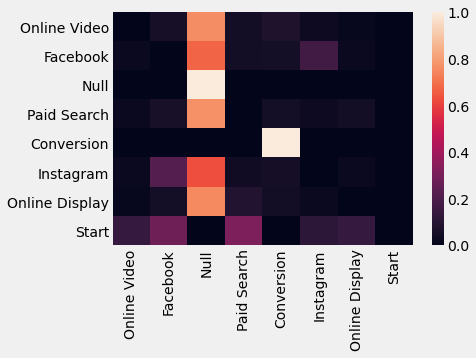

In [18]:
sns.heatmap(trans_matrix)

# MARKOV CHAIN

In [19]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [20]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

# RESULTS

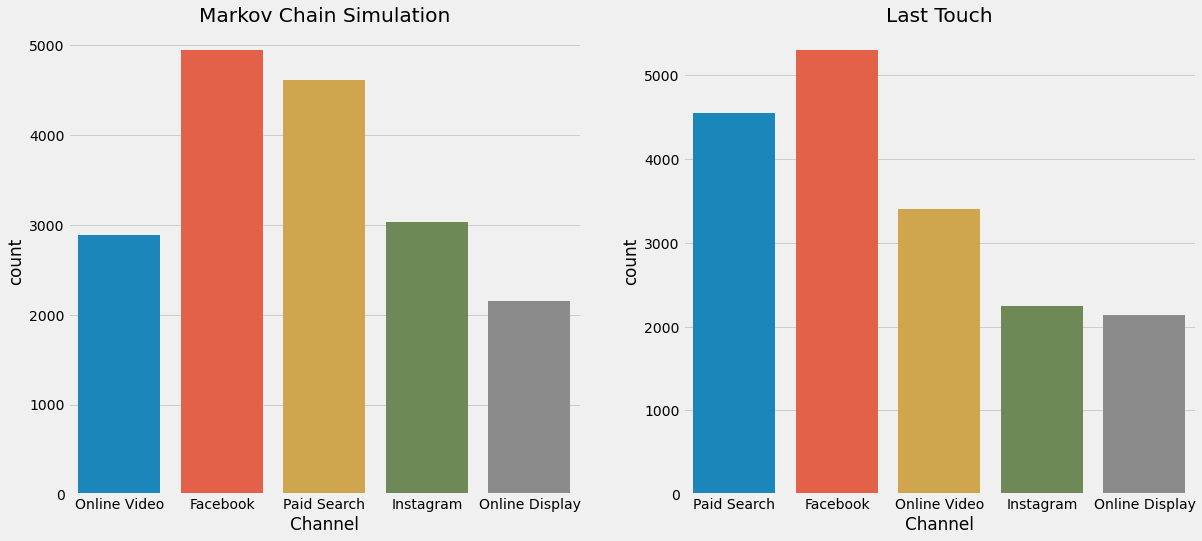

In [21]:
my_df = pd.DataFrame(attributions.items())
fig,axs = plt.subplots(1,2,figsize = (18,8))
sns.barplot(x=0, y=1, data=my_df, ax= axs[0])
axs[0].set(xlabel = 'Channel', ylabel='count', title='Markov Chain Simulation')
df_converted_data = df_cookie_data[df_cookie_data.conversion==1].loc[:,['cookie','conversion','channel']]
sns.countplot(x= 'channel',data=df_converted_data, ax = axs[1])
axs[1].set(xlabel = 'Channel', ylabel='count', title='Last Touch')
plt.show()